## Look at tasks that spread over multiple days

In [182]:
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId
from datetime import datetime
import itertools
import re
import matplotlib.pylab as pylab
import numpy as np
from scipy import percentile
from scipy.stats import pearsonr, kendalltau
import math

# DB connection to localhost
client = MongoClient()
# Get DB
db = client.db_tasklog_clean
# collection to store new data that contains task labels
# Note: only top-level task labels are used
DataLabeled = db.data_labeled
Users = db.user

users = list(Users.find({}))

In [115]:
# Flatten the data to streams of events
D = []
# Get tasks length
for u in users:
    data = list(DataLabeled.find({'userid': u['userid']}))[0]['data']
    events = []
    # data consists of tab-groups
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        # tab groups consist of url groups
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            for e in url_group:
                events.append(e)
    D.append((u['userid'], events))
            

In [130]:
# Tasks to be filtered out
Filter = ['None', '000', '001', '002', '003', '004']
# Tasks annotated with postQ
postQ = [u['postQ']['questionnaire'].keys() for u in users]
postQ_tasks = [x for sublist in postQ for x in sbublist]

In [175]:
# Get task properties
T_prop = {}
bloom_map = {
    'remember': 1,
    'understadn': 2,
    'apply': 3,
    'analyse': 4,
    'evaluate': 5,
    'create': 6
}
for u in users:
    Q = u['postQ']['questionnaire']
    for q in Q:
        for question in Q[q].keys():
            answers = T_prop.get(question, [])
            a = Q[q][question]
            # process bloom's taxonomy
            if question == 'task_complexity_objective':
                a = bloom_map[a]
            answers.append({q, a})
            T_prop[question] = answers

## Descriptive stats
* How many tasks spreads over days (and annotated with postQ)
* How many queries would users go before first click (cf. Daan)
* How often do people directly go to a website to solve their (long term) tasks instead of using a SE? 
* How often do people need to re-issue the same queries in a different session for the same task?
* How different are queries issued in the same session of the same task? and in the different sessions of the same task? (exploration vs. struggling?)

### Number of tasks spread over days (or multiple hours)
1. All tasks
2. Tasks that have postQ annotations

### Stats
 - in both cases, about half of the tasks spread over days
 - in both cases, about half of the tasks accomplished within a day need more than 1 hour

In [169]:
# Task length in terms of total seconds
T_length = {}
T = []
# How many tasks spread over days?
# For tasks finished wihtin a day, how many hours do they spread over?
# Count for tasks spread over days
Days = []
Days_Q = []
# Count for tasks within a day, spread over hours
Hours = []
Hours_Q = []
for uid, data in D:
    tasks = [(d['taskid'], d['timestamp_bson']) for d in data if d['taskid'] not in Filter]
    tasks.sort(key=lambda x: x[0])
    for k, g in itertools.groupby(tasks, lambda x: x[0]):
        g = sorted(list(g), key=lambda x: x[1])
        
        # Get task length
        T_length[k] = (g[-1][1] - g[0][1]).total_seconds()
        
        # Get task length in terms of days
        days = (g[-1][1] - g[0][1]).days + 1
        Days.append((k, days))
        if k in postQ_tasks:
            Days_Q.append((k, days))
            
        # Get task length in terms of hours if they are completed within 1 day
        if days == 1:
            hours = round((g[-1][1] - g[0][1]).total_seconds()/(60*60))
            Hours.append((k, hours))
            if k in postQ_tasks:
                Hours_Q.append((k, hours))

% Tasks completed within 1 day: 0.51
% Tasks completed over multiple days: 0.49
Number of tasks completed within 1 day: 88
Number of tasks completed over multiple days: 84


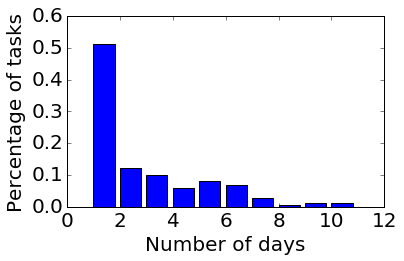

In [183]:
# Plot the distributsion of tasks spread over days
pylab.figure()
tot_tasks = float(len(Days))
Days.sort(key=lambda x: x[1])
X = []
Y = []
C = []
for k, g in itertools.groupby(Days, lambda x: x[1]):
    g = list(g)
    X.append(k)
    Y.append(len(g)/tot_tasks)
    C.append(len(g))
    
pylab.bar(X, Y)
pylab.xlabel('Number of days')
pylab.ylabel('Percentage of tasks')
pylab.tight_layout()
pylab.savefig('plots/tasks_overdays.pdf')
print '% Tasks completed within 1 day:',  '%.2f'%Y[0]
print '% Tasks completed over multiple days:', '%.2f'%sum(Y[1:])
print 'Number of tasks completed within 1 day:', C[0]
print 'Number of tasks completed over multiple days:', sum(C[1:])

Tasks annotated by postQ
% Tasks completed within 1 day: 0.43
% Tasks completed over multiple days: 0.57
Number of tasks completed within 1 day: 37
Number of tasks completed over multiple days: 49


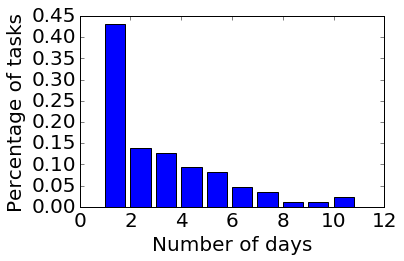

In [184]:
# Plot the distributsion of tasks spread over days annotated by postQ
pylab.figure()
tot_tasks = float(len(Days_Q))
Days_Q.sort(key=lambda x: x[1])
X = []
Y = []
C = []
for k, g in itertools.groupby(Days_Q, lambda x: x[1]):
    g = list(g)
    X.append(k)
    Y.append(len(g)/tot_tasks)
    C.append(len(g))
    
pylab.bar(X, Y)
pylab.xlabel('Number of days')
pylab.ylabel('Percentage of tasks')
pylab.tight_layout()
pylab.savefig('plots/postQ_tasks_overdays.pdf')

print 'Tasks annotated by postQ'
print '% Tasks completed within 1 day:',  '%.2f'%Y[0]
print '% Tasks completed over multiple days:', '%.2f'%sum(Y[1:])
print 'Number of tasks completed within 1 day:', C[0]
print 'Number of tasks completed over multiple days:', sum(C[1:])

% Tasks completed within 1 hour: 0.47
% Tasks completed over multiple hours: 0.53
Number of tasks completed within 1 hour: 41
Number of tasks completed over multiple hours: 47


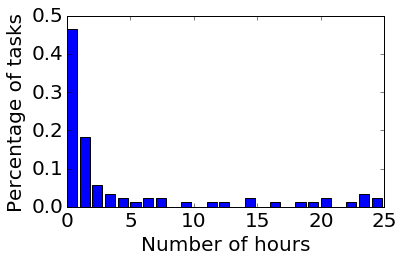

In [185]:
# Plot the distribution of hours for tasks completed within 1 day
pylab.figure()
tot_tasks_1day = float(len(Hours))
Hours.sort(key=lambda x: x[1])
X = []
Y = []
C = []
for k, g in itertools.groupby(Hours, lambda x: x[1]):
    g = list(g)
    X.append(k)
    Y.append(len(g)/tot_tasks_1day)
    C.append(len(g))
pylab.bar(X, Y)
pylab.xlabel('Number of hours')
pylab.ylabel('Percentage of tasks')
pylab.tight_layout()
pylab.savefig('plots/tasks_overhours.pdf')

print '% Tasks completed within 1 hour:',  '%.2f'%Y[0]
print '% Tasks completed over multiple hours:', '%.2f'%sum(Y[1:])
print 'Number of tasks completed within 1 hour:', C[0]
print 'Number of tasks completed over multiple hours:', sum(C[1:])

Tasks annotated by postQ
% Tasks completed within 1 hour: 0.38
% Tasks completed over multiple hours: 0.62
Number of tasks completed within 1 hour: 14
Number of tasks completed over multiple hours: 23


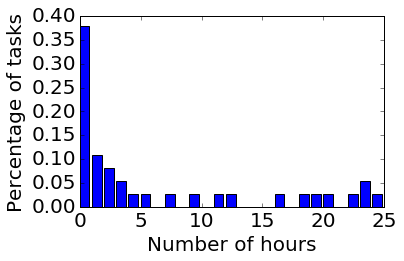

In [186]:
# Plot the distribution of hours for tasks completed within 1 day (annotated by postQ)
pylab.figure()
tot_tasks_1day = float(len(Hours_Q))
Hours_Q.sort(key=lambda x: x[1])
X = []
Y = []
C = []
for k, g in itertools.groupby(Hours_Q, lambda x: x[1]):
    g = list(g)
    X.append(k)
    Y.append(len(g)/tot_tasks_1day)
    C.append(len(g))
pylab.bar(X, Y)
pylab.xlabel('Number of hours')
pylab.ylabel('Percentage of tasks')
pylab.tight_layout()
pylab.savefig('plots/postQ_tasks_overdays.pdf')

print 'Tasks annotated by postQ'
print '% Tasks completed within 1 hour:',  '%.2f'%Y[0]
print '% Tasks completed over multiple hours:', '%.2f'%sum(Y[1:])
print 'Number of tasks completed within 1 hour:', C[0]
print 'Number of tasks completed over multiple hours:', sum(C[1:])